# Tuning and Validating Model Thresholds

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd

from sklearn.metrics import recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest

# Imports for analysis

# OS imports
from os.path import join as ospj
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'
jet_cmap = cm.get_cmap('Spectral')

In [3]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['font.family'] = 'Verdana'

In [4]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

def apply_specificity(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = np.atleast_1d(wideform_preds(row[col],all_chs))
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_spec'] = recall_score(row[col+'_bool']==False,ch_preds==False)
    return row

def apply_region_kappa(row):
    all_rs = row.all_rs
    for col in ['ueo_rs_strict','ueo_rs_loose','sec_rs_strict','ueo_rs_loose']:
        bool_col = wideform_preds(row[col],all_rs)
        for annot in ['consensus','any']:
            r_annots = wideform_preds(row[f'{col[:3]}_{annot}_rs'],all_rs)
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(bool_col,r_annots)
    return row

def apply_region_dice(row):
    all_rs = row.all_rs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_mcc(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_MCC'] = matthews_corrcoef(row[col+'_bool'],ch_preds)
    return row

def test_against_annots(mdl_annots,clin_annots):
    clin_annots.sort_values('approximate_onset',inplace=True)
    mdl_annots.sort_values('approximate_onset',inplace=True)
    mdl_annots.rename(columns={'Patient':'patient'},inplace=True)
    clin_annots_mdl = clin_annots[clin_annots.patient.isin(mdl_annots.patient)].dropna().sort_values('approximate_onset')
    mdl_annots_clin = mdl_annots[mdl_annots.patient.isin(clin_annots_mdl.patient)]
    x = pd.merge_asof(mdl_annots,clin_annots_mdl[['patient','approximate_onset','f1']],on='approximate_onset',by='patient',tolerance=60,direction='nearest').dropna()
    all_ps = []
    for mdl in x.model.unique():
        y = x[x.model==mdl]
        res = sc.stats.wilcoxon(y.dice,y.f1,alternative='less')
        # all_ps.append()
        print(mdl,': ',res)
    print()
    
# Required descriptors for annotate
custom_long_name = 'One-sided Wilcoxin statistical test'
custom_short_name = 'WG'
def custom_stat(x,y):
    return sc.stats.wilcoxon(x,y,alternative='less')
custom_test = StatTest(custom_stat, custom_long_name, custom_short_name)

## Config

In [5]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/sauce/littlab/users/wojemann/stim-seizures/code','config.json'))

## Calculating clinician consensus

In [6]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus_v2.pkl'))
consensus_annots.loc[consensus_annots.Seizure_ID == 'HUP249_3','stim'] = 1.0
consensus_annots = consensus_annots[consensus_annots.patient != 'CHOP038']

In [7]:
# consensus_annots = consensus_annots[consensus_annots.stim == 0]
# Potentially put this back in for older version of results
# consensus_annots = consensus_annots[consensus_annots.clinician.apply(lambda x: len(x)!=2)]
spread_consensus_annots = consensus_annots.copy()
note_type = 'ueo'
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2: 
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += matthews_corrcoef(annots[i_annot],annots[j_annot])
    consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]

note_type = 'sec'
for i_r, row in spread_consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2: 
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += matthews_corrcoef(annots[i_annot],annots[j_annot])
    spread_consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
spread_consensus_annots["model"] = ["Clin."]*len(spread_consensus_annots)
spread_consensus_annots["dice"] = spread_consensus_annots["f1"]

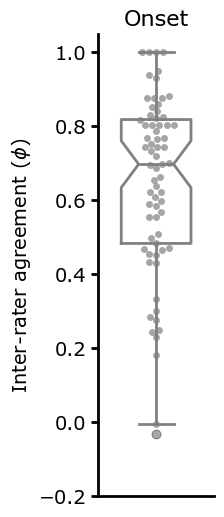

0.6436884593447756


In [8]:
plt.figure(figsize=(1.5,6))
sns.boxplot(consensus_annots["dice"],color='gray',fill=False,notch=True,width=0.6)
sns.swarmplot(consensus_annots["dice"],color='gray',alpha=0.7)
# sns.pointplot(all_dice,color='gray',marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title('Onset');
plt.ylabel('Inter-rater agreement ($\phi$)');
plt.ylim([-.2,1.05]);
plt.xticks([]);
plt.savefig(ospj(figpath,'onset_interrater_agreement.pdf'),transparent=True,bbox_inches='tight')
plt.show()
print(consensus_annots.dice.mean())


0.6293227173349164


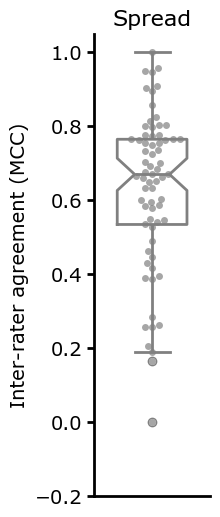

In [9]:
plt.figure(figsize=(1.5,6))
sns.boxplot(spread_consensus_annots["dice"],color='gray',fill=False,notch=True,width=.6)
sns.swarmplot(spread_consensus_annots["dice"],color='gray',alpha=0.7)
# sns.pointplot(all_dice,color='gray',marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title('Spread');
plt.ylabel('Inter-rater agreement (MCC)');
plt.ylim([-.2,1.05]);
plt.xticks([]);
plt.savefig(ospj(figpath,'spread_interrater_agreement.pdf'),transparent=True,bbox_inches='tight')
print(spread_consensus_annots.dice.mean())

In [10]:
sc.stats.wilcoxon(consensus_annots["dice"].dropna(),spread_consensus_annots["dice"].dropna())

WilcoxonResult(statistic=1121.0, pvalue=0.6050313092068609)

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

onset vs. spread: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:6.050e-01 Stat=1.121e+03


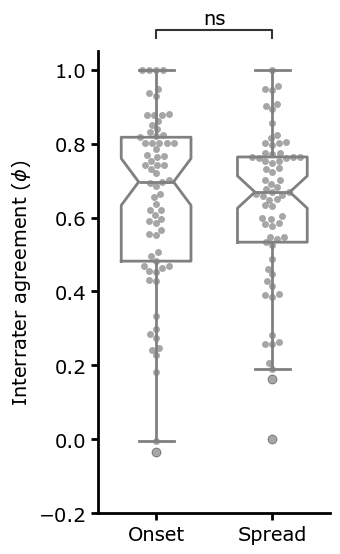

In [11]:
consensus_annots['type'] = 'onset'
spread_consensus_annots['type'] = 'spread'
all_plot_annots = pd.concat([consensus_annots,spread_consensus_annots],axis=0).reset_index(drop=True)
plt.figure(figsize=(3,6))
sns.boxplot(all_plot_annots,x='type',y='dice',color='gray',fill=False,notch=True,width=.6)
ax = sns.swarmplot(all_plot_annots,x='type',y='dice',color='gray',alpha=0.7)
# sns.pointplot(all_dice,color='gray',marker='_',markersize=40,errorbar=None)
annotator = Annotator(ax,[('onset','spread')],data=all_plot_annots,order=['onset','spread'],x='type',y='dice')
annotator.configure(test='Wilcoxon',
        comparisons_correction="Benjamini-Hochberg",
        loc='outside',
        text_format='star',
        fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                        [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]])
annotator.apply_and_annotate()
sns.despine()
# plt.title('Spread');
plt.ylabel('Interrater agreement ($\phi$)');
plt.ylim([-.2,1.05]);
plt.xticks([0,1],['Onset','Spread']);
plt.xlabel('')
plt.savefig(ospj(figpath,'comparative_interrater_agreement.pdf'),transparent=True,bbox_inches='tight')

## Supervised Thresholding

### Data Prep

In [12]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
# mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wmcc_nosmooth.pkl"))
# mdl_preds = pd.read_pickle('/mnt/sauce/littlab/users/wojemann/stim-seizures/PROCESSED_DATA/pretrain_predicted_channels_wmcc_epoch-10_min-False_mov-mean-20-prob.pkl')
mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wmcc_epoch-10_min-False_mov-mean-20-prob_v2.pkl"))
mdl_preds = mdl_preds[mdl_preds.model != 'NRG']
mdl_preds.loc[mdl_preds.approximate_onset == 439029.32,'stim'] = 1.0

In [13]:
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [14]:
print('Stim Seizures: ',len(mdl_preds[mdl_preds.stim==1].approximate_onset.unique()))
print('All Seizures: ',mdl_preds.approximate_onset.nunique())
print('All Patients',len(mdl_preds.Patient.unique()))
print('HUP Patients', len(mdl_preds[mdl_preds.Patient.apply(lambda x: 'HUP' in x)].Patient.unique()))
print('HUP Seizures: ', len(mdl_preds[mdl_preds.Patient.apply(lambda x: 'HUP' in x)].approximate_onset.unique()))
x = pd.merge_asof(consensus_annots.sort_values('approximate_onset')[['patient','approximate_onset','clinician']],
mdl_preds.sort_values('approximate_onset').rename(columns={'Patient':'patient'}),
on='approximate_onset',by='patient',tolerance=120,direction='nearest')
x['nannot'] = x.clinician.apply(len)
print('Annotator Distribution: \n',x.groupby('nannot').count()['patient'].reset_index().values)

Stim Seizures:  36
All Seizures:  80
All Patients 29
HUP Patients 19
HUP Seizures:  63
Annotator Distribution: 
 [[ 1 16]
 [ 2  2]
 [ 3 57]
 [ 5 10]]


In [15]:
melt_cols = [f'ueo_chs_{mdl_anntype}_{anntype}_MCC',f'sec_chs_{mdl_anntype}_{anntype}_MCC']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')

In [16]:
tune_preds_long = mdl_preds_long[mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC']
val_preds_long = mdl_preds_long[mdl_preds_long.annot == f'sec_chs_{mdl_anntype}_{anntype}_MCC']

### Threshold sweeping

In [17]:
mdl_preds_long.Patient.unique()

array(['CHOP005', 'CHOP024', 'CHOP026', 'CHOP028', 'CHOP035', 'CHOP037',
       'CHOP041', 'CHOP044', 'CHOP045', 'CHOP049', 'HUP224', 'HUP225',
       'HUP229', 'HUP230', 'HUP235', 'HUP238', 'HUP246', 'HUP247',
       'HUP249', 'HUP250', 'HUP253', 'HUP257', 'HUP261', 'HUP263',
       'HUP266', 'HUP267', 'HUP273', 'HUP275', 'HUP288'], dtype=object)

#### Comparing thesholds by stim

In [18]:
# fig,axs = plt.subplots(1,2)
# sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC'],x='threshold',y='dice',hue='model',ax=axs[0])
# axs[0].set_ylim((-.1,.7))
# axs[0].set_title('Onset Annots')
# # axs[0].axvline(1.33)
# sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_chs_{mdl_anntype}_{anntype}_MCC'],x='threshold',y='dice',hue='model',ax=axs[1],legend=False)
# axs[1].set_ylim((-.1,.7))
# axs[1].set_yticks([])
# axs[1].set_ylabel('')
# axs[1].set_title('Spread Annots')
# fig.suptitle(f'Model Annotator Agreement - {anntype}')
# # fig.savefig(ospj(figpath,f'ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

In [19]:
print(mdl_preds_sorted[(mdl_preds_sorted.model == 'LSTM') & (mdl_preds_sorted.stim==0)].groupby('threshold')['ueo_chs_strict_consensus_MCC'].mean().idxmax())
print(mdl_preds_sorted[(mdl_preds_sorted.model == 'LSTM') & (mdl_preds_sorted.stim==1)].groupby('threshold')['ueo_chs_strict_consensus_MCC'].mean().idxmax())
print(mdl_preds_sorted[(mdl_preds_sorted.model == 'LSTM')].groupby('threshold')['ueo_chs_strict_consensus_MCC'].mean().idxmax())

1.4846461949265688
1.6875834445927904
1.479305740987984


In [20]:
opt_thresh_df = (
    mdl_preds_sorted[mdl_preds_sorted.model == 'LSTM']
    .groupby(['stim', 'approximate_onset', 'threshold'])['ueo_chs_strict_consensus_MCC']
    .mean()
    .reset_index()
    .sort_values(['stim', 'approximate_onset', 'ueo_chs_strict_consensus_MCC'], ascending=[True, True, False])
    .groupby(['stim', 'approximate_onset'])
    .first()
    .reset_index()
)
opt_thresh_df['stim'] = opt_thresh_df['stim'].map({1.0:'Stim',0.0:'Spont'})
opt_thresh_df.rename(columns={'stim':'Sz Type'},inplace=True)

opt_thresh_ptdf = (
    mdl_preds_sorted[mdl_preds_sorted.model == 'LSTM']
    .groupby(['stim', 'Patient', 'threshold'])['ueo_chs_strict_consensus_MCC']
    .mean()
    .reset_index()
    .sort_values(['stim', 'Patient', 'ueo_chs_strict_consensus_MCC'], ascending=[True, True, False])
    .groupby(['stim', 'Patient'])
    .first()
    .reset_index()
)
opt_thresh_ptdf['stim'] = opt_thresh_ptdf['stim'].map({1.0:'Stim',0.0:'Spont'})
opt_thresh_ptdf.rename(columns={'stim':'Sz Type'},inplace=True)

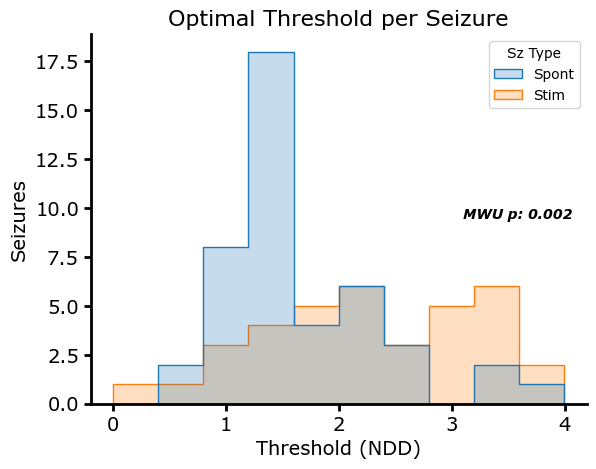

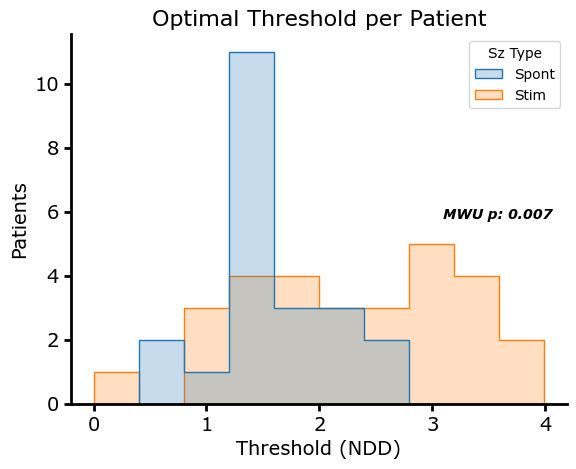

In [21]:
ax = sns.histplot(opt_thresh_df,x='threshold',hue='Sz Type',element='step',bins=10)
sns.despine()
plt.ylabel('Seizures')
plt.xlabel('Threshold (NDD)')
p = np.round(sc.stats.mannwhitneyu(opt_thresh_df.query('`Sz Type`=="Spont"').threshold,opt_thresh_df.query('`Sz Type`=="Stim"').threshold).pvalue,3)
plt.text(.75,.5,
f'MWU p: {p}',
transform=ax.transAxes,
fontdict=dict(weight='bold',style='italic'))
plt.title('Optimal Threshold per Seizure')
plt.show()

ax = sns.histplot(opt_thresh_ptdf,x='threshold',hue='Sz Type',element='step',bins=10)
sns.despine()
plt.ylabel('Patients')
plt.xlabel('Threshold (NDD)')
p = np.round(sc.stats.mannwhitneyu(opt_thresh_ptdf.query('`Sz Type`=="Spont"').threshold,opt_thresh_ptdf.query('`Sz Type`=="Stim"').threshold).pvalue,3)
plt.text(.75,.5,
f'MWU p: {p}',
transform=ax.transAxes,
fontdict=dict(weight='bold',style='italic'))
plt.title('Optimal Threshold per Patient')
plt.show()

#### LOPO CVAL

Population average AbsSlp threshold: (0.19123911246741687, array([0.19225634, 0.19225634]))
Cross-validated estimation of AbsSlp MCC: 0.2136705975331736


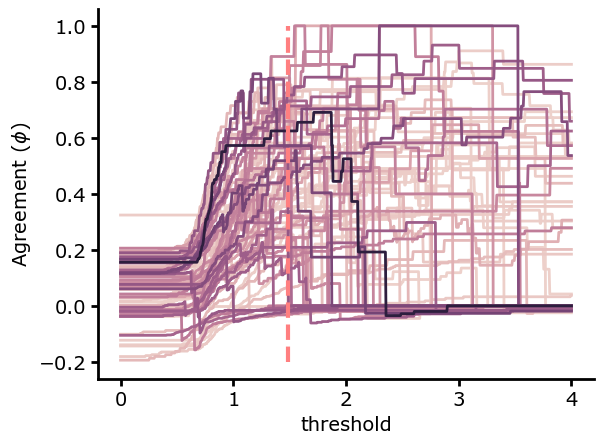

1.4846461949265688
Population average LSTM threshold: (1.4897323415347448, array([1.48464619, 1.48464619]))
Cross-validated estimation of LSTM MCC: 0.4184684622945556
Population average WVNT threshold: (0.3855299128997393, array([0.38451268, 0.38451268]))
Cross-validated estimation of WVNT MCC: 0.3721584999269162


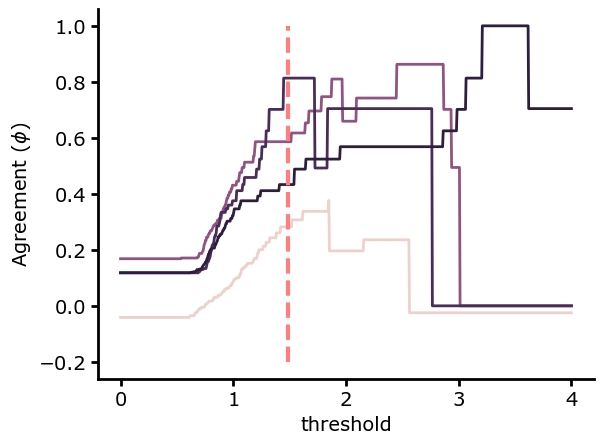

In [22]:
from sklearn.model_selection import KFold
dict_list = []
for model in mdl_preds_sorted.model.unique():   
    # Assuming the DataFrame is named 'df' and already loaded
    df = mdl_preds_sorted[(mdl_preds_sorted['model'] == model) & (mdl_preds_sorted['stim'] == 0)]
    # Get unique patients
    unique_patients = df['Patient'].unique()

    # Create a KFold object to split patients
    kf = KFold(n_splits=len(unique_patients)-1, shuffle=False)
    # len(unique_patients)-1
    optimal_thresholds = []
    cross_validated_mccs = []

    for fold, (train_index, test_index) in enumerate(kf.split(unique_patients), 1):
        train_patients = unique_patients[train_index]
        test_patients = unique_patients[test_index]

        # Create training and test DataFrames based on patient splits
        train_df = df[df['Patient'].isin(train_patients)]
        test_df = df[df['Patient'].isin(test_patients)]

        # Calculate average MCC for each threshold in the training set
        average_mcc_per_threshold = train_df.groupby('threshold')['ueo_chs_strict_consensus_MCC'].mean()

        # Find the optimal threshold
        optimal_threshold = average_mcc_per_threshold.idxmax()
        optimal_thresholds.append(optimal_threshold)
        
        # Calculate MCC for each seizure in the test set at the optimal threshold
        test_seizures = test_df[test_df['threshold'] == optimal_threshold]
        for onset, seizure in test_seizures.groupby('approximate_onset'):
            cross_validated_mccs.extend(seizure['ueo_chs_strict_consensus_MCC'].values)
            dict_list.append({
                'patient': seizure.Patient.values[0],
                'approximate_onset': onset,
                'model': model,
                'stim': seizure.stim.values[0],
                'dice': seizure['ueo_chs_strict_consensus_MCC'].values[0],
                'threshold': optimal_threshold
            })
            if (test_df.Patient.iloc[0] == 'HUP238') & (onset == 290006.91) &(test_df.model.iloc[0] == 'LSTM'):
                ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.Patient != 'HUP238') & (mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') & (mdl_preds_long.model == 'LSTM')],
                hue_order='Patient',
                x='threshold',
                y='dice',
                hue='approximate_onset',
                # palette='Spectral',
                errorbar=None,legend=False)

                ax.plot([optimal_threshold,optimal_threshold],[-.2,1],
                c=sns.color_palette('spring_r',n_colors=3)[1],
                linewidth=3,
                linestyle='--')
                plt.ylabel('Agreement ($\phi$)')
                sns.despine()
                plt.show()

                bx = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.Patient == 'HUP238') & (mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') & (mdl_preds_long.model == 'LSTM')],
                hue_order='Patient',
                x='threshold',
                y='dice',
                hue='approximate_onset',
                color='purple',
                # palette='Spectral',
                errorbar=None,legend=False)

                bx.plot([optimal_threshold,optimal_threshold],
                [-.2,1],
                c=sns.color_palette('spring_r',n_colors=3)[1],
                linestyle='--',
                linewidth=3)
                sns.despine()
                bx.set_ylabel('Agreement ($\phi$)')
                print(optimal_threshold)
    # Calculate the population average threshold
    population_average_threshold = np.mean(optimal_thresholds)

    # Calculate the cross-validated estimation of MCC
    cross_validated_mcc = np.mean(cross_validated_mccs)

    print(f"Population average {model} threshold: {population_average_threshold,np.percentile(optimal_thresholds,[25,75])}")
    print(f"Cross-validated estimation of {model} MCC: {cross_validated_mcc}")
cval_preds = pd.DataFrame(dict_list)
cval_preds.loc[cval_preds.model == 'LSTM','model'] = 'NDD'
cval_preds.loc[cval_preds.model == 'WVNT','model'] = 'DL'

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DL vs. NDD: One-sided Wilcoxin statistical test with Benjamini-Hochberg correction, P_val:8.303e-02 Stat=2.750e+02
AbsSlp vs. NDD: One-sided Wilcoxin statistical test with Benjamini-Hochberg correction, P_val:3.773e-04 Stat=1.940e+02


Text(1.0138888888888875, 0.5, 'Agreement ($\\phi$)')

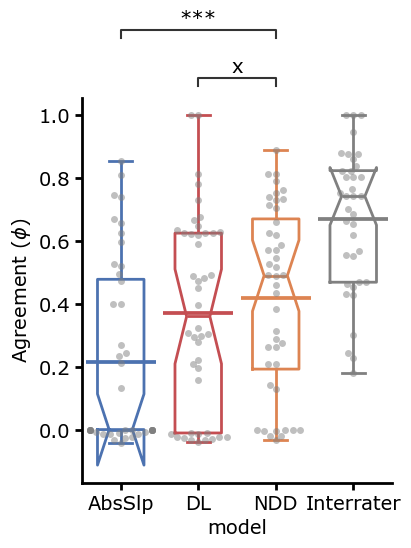

In [23]:
consensus_annots["model"] = ["Interrater"]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
cval_consensus_annots = consensus_annots[consensus_annots.stim == 0]
cval_plot_agreements = pd.concat([cval_preds,cval_consensus_annots[['patient',"model","dice","stim"]]]).dropna(subset='dice').reset_index(drop=True)
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
_,ax = plt.subplots(figsize=(4,5))
sns.boxplot(cval_plot_agreements,x='model',y='dice',hue='model',palette=np.vstack([colors,[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],
                 hue_order=['AbsSlp','DL','NDD','Interrater'],
                 width=.6,notch=True,fill=False,
                 ax=ax)

sns.swarmplot(cval_plot_agreements,x='model',y='dice',color='gray',ax=ax,alpha=0.5)
sns.pointplot(cval_plot_agreements,x='model',y='dice',
              palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              hue_order = ['AbsSlp','DL','NDD','Interrater'],
              order = ['AbsSlp','DL','NDD','Interrater'],
              marker='_',markersize=50,errorbar=None,
              estimator='mean',
              ax=ax)
annotator = Annotator(ax,[('NDD','DL'),('NDD','AbsSlp')],data=cval_plot_agreements,order=['AbsSlp','DL','NDD','Interrater'],x='model',y='dice')
annotator.configure(test=custom_test,
        comparisons_correction="Benjamini-Hochberg",
        loc='outside',
        text_format='star',
        fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                        [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]])
annotator.apply_and_annotate()
sns.despine()
plt.ylabel('Agreement ($\phi$)')
# plt.title('LOPO Onset Activity Detection')

In [24]:
test_against_annots(cval_preds,cval_consensus_annots)

AbsSlp :  WilcoxonResult(statistic=30.0, pvalue=5.922629497945309e-08)
NDD :  WilcoxonResult(statistic=99.0, pvalue=0.00010392963304184377)
DL :  WilcoxonResult(statistic=67.0, pvalue=4.0601987576459466e-05)



#### Individual plotting

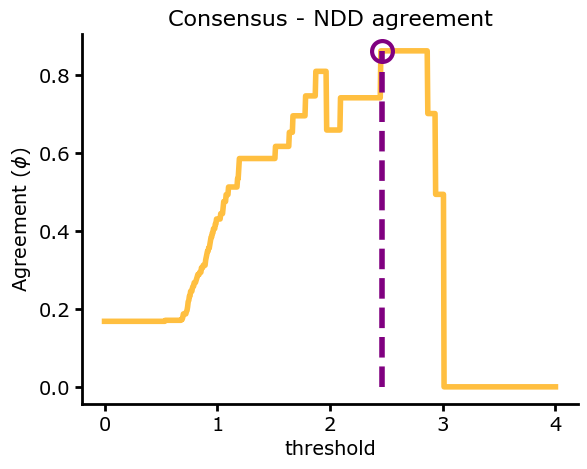

In [25]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') & (mdl_preds_long.model == 'LSTM')& (mdl_preds_long.Patient == 'HUP238')& (mdl_preds_long.approximate_onset == 290006.91)],
x='threshold',y='dice',
color=sns.color_palette('spring_r',n_colors=3)[0],
errorbar=None,
legend=False,
linewidth=4)
# plt.xlim([0,1])
# plt.axvline(2.4085447263017357,c='black',linestyle='--')
ax.plot([2.4585447263017357]*2,[0,0.8626358588651414],'--o',c='purple',
markersize=15,
linewidth=4,
markevery=[1],
fillstyle='none',
markeredgewidth=3)
plt.title('Consensus - NDD agreement')
plt.ylabel('Agreement ($\phi$)')
sns.despine()

### Tuning at the seizure level

#### Onset

In [26]:
optimal_threshold_preds = tune_preds_long.loc[tune_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset",'threshold']]#,'ueo_chs_loose','ueo_consensus_chs']]

In [27]:
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
# consensus_annots = consensus_annots[consensus_annots.stim == 0]
all_plot_agreements = pd.concat([optimal_threshold_preds,consensus_annots[["model","dice","stim"]]]).dropna(subset='dice')

In [28]:
test_against_annots(optimal_threshold_preds,consensus_annots)

AbsSlp :  WilcoxonResult(statistic=357.0, pvalue=4.159087269129058e-06)
LSTM :  WilcoxonResult(statistic=904.0, pvalue=0.23823398984010496)
WVNT :  WilcoxonResult(statistic=486.0, pvalue=0.00017600872165417718)



In [29]:
# all_plot_agreements = pd.concat([all_plot_agreements,external_annots])
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DL vs. NDD: One-sided Wilcoxin statistical test with Benjamini-Hochberg correction, P_val:1.043e-04 Stat=5.250e+02
AbsSlp vs. NDD: One-sided Wilcoxin statistical test with Benjamini-Hochberg correction, P_val:1.348e-05 Stat=4.860e+02


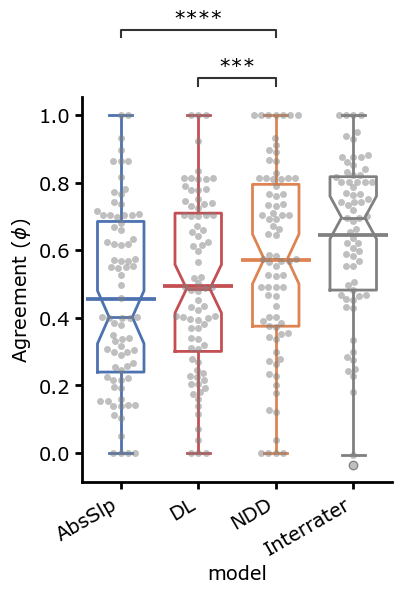

In [30]:
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
_,ax = plt.subplots(figsize=(4,5))
sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([colors,[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],
                 width=.6,notch=True,fill=False,ax=ax)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray',ax=ax,alpha=0.5)
sns.pointplot(all_plot_agreements,x='model',y='dice',
              palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','DL','NDD','Interrater'],
              marker='_',markersize=50,errorbar=None,ax=ax,
              estimator='mean')
sns.despine()

# Annotating plot
annotator = Annotator(ax,[('NDD','DL'),('NDD','AbsSlp')],data=all_plot_agreements,order=['AbsSlp','DL','NDD','Interrater'],x='model',y='dice')
annotator.configure(test=custom_test,
        comparisons_correction="Benjamini-Hochberg",
        loc='outside',
        text_format='star',
        fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                        [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]])
annotator.apply_and_annotate()

plt.ylabel('Agreement ($\phi$)')
# plt.title("Onset Activity Encoding")
plt.xticks(rotation=30,ha='right')
plt.savefig(ospj(figpath,'onset_tuned_onset_detection.pdf'),bbox_inches='tight')

#### Spread

In [31]:
val_tuned_thresholds = val_preds_long.loc[val_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset",'threshold']]

In [32]:
spread_consensus_annots["model"] = ["Clin."]*len(spread_consensus_annots)
# spread_consensus_annots = spread_consensus_annots[spread_consensus_annots.stim == 0]
all_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])

In [33]:
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'

In [34]:
test_against_annots(val_tuned_thresholds,spread_consensus_annots)

AbsSlp :  WilcoxonResult(statistic=831.0, pvalue=0.11280205052180015)
LSTM :  WilcoxonResult(statistic=1167.0, pvalue=0.8618195217068196)
WVNT :  WilcoxonResult(statistic=824.0, pvalue=0.10389184231659143)



p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DL vs. NDD: One-sided Wilcoxin statistical test with Benjamini-Hochberg correction, P_val:4.914e-07 Stat=2.640e+02
AbsSlp vs. NDD: One-sided Wilcoxin statistical test with Benjamini-Hochberg correction, P_val:5.632e-05 Stat=5.010e+02


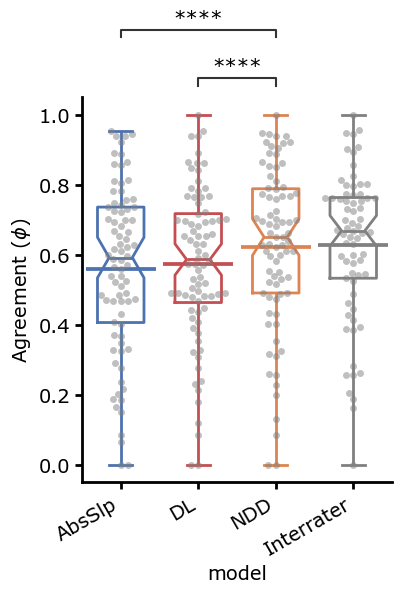

In [35]:
_,ax = plt.subplots(figsize=(4,5))
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray', order = ['AbsSlp','DL','NDD','Interrater'],ax=ax,alpha=.5)
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','DL','NDD','Interrater'],marker='_',markersize=50,errorbar=None,ax=ax,
              estimator='mean')
sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],width=.6,notch=True,fill=False,whis=100,ax=ax)
sns.despine()

def custom_stat(x,y):
    return sc.stats.wilcoxon(x,y,alternative='less')
custom_test = StatTest(custom_stat, custom_long_name, custom_short_name)

# Annotating plot
annotator = Annotator(ax,[('NDD','DL'),('NDD','AbsSlp')],data=all_plot_agreements,order=['AbsSlp','DL','NDD','Interrater'],x='model',y='dice')
annotator.configure(test=custom_test,
        comparisons_correction="Benjamini-Hochberg",
        loc='outside',
        text_format='star',
        fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                        [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]])
annotator.apply_and_annotate()

plt.xticks(rotation=30,ha='right')
plt.ylabel('Agreement ($\phi$)')
# plt.title("Spread Activity Encoding")
plt.savefig(ospj(figpath,'spread_tuned_spread_detection.pdf'),bbox_inches='tight')

In [36]:
sc.stats.mannwhitneyu(all_plot_agreements[(all_plot_agreements.stim == 0) & (all_plot_agreements.model == 'NDD')].dice,
all_plot_agreements[(all_plot_agreements.stim == 1) & (all_plot_agreements.model == 'NDD')].dice)

MannwhitneyuResult(statistic=1187.5, pvalue=0.00013340719342381255)

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.334e-04 U_stat=1.188e+03


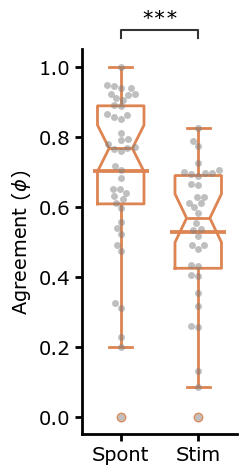

In [37]:
fig,ax=plt.subplots(figsize=(2,5))
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[1,1]]
stim_plot_agreements = all_plot_agreements[all_plot_agreements.model == 'NDD']
sns.swarmplot(stim_plot_agreements,x='stim',y='dice',color='gray',alpha=0.5)
sns.pointplot(stim_plot_agreements,x='stim',y='dice',palette=colors,
            marker='_',markersize=40,errorbar=None,estimator='mean')
sns.boxplot(stim_plot_agreements,x='stim',y='dice',palette=colors,width=.6,notch=True,fill=False)
sns.despine()
plt.xticks([0,1],['Spont','Stim'])
# plt.title("Ictal Transition Encoding - Patient Threshold")
plt.xlabel('')
plt.ylabel('Agreement ($\phi$)')
annotator = Annotator(ax,[(True,False)],data=stim_plot_agreements,x='stim',y='dice')
annotator.configure(test='Mann-Whitney',
        loc='outside',
        text_format='star',
        fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                        [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]])
annotator.apply_and_annotate()
plt.savefig(ospj(figpath,'stim_vs_spont_detection.pdf'),bbox_inches='tight')

## Unsupervised Model Predictions

In [38]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus_v2.pkl"))
# annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
# predicted_channels = pd.read_pickle(ospj(prodatapath,"gamma_predicted_channels_opt.pkl"))
# predicted_channels = pd.read_pickle(ospj(prodatapath,"kdeknee_predicted_channels_nor.pkl"))
predicted_channels = pd.read_pickle(ospj(prodatapath,"DynaSD_gaussianx_automedian_predicted_channels_norp_valtuned_v2.pkl"))
# predicted_channels = pd.read_pickle(ospj(prodatapath,"DynaSD_90centile_predicted_channels_nor.pkl"))


# predicted_channels = 
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]
predicted_channels.loc[predicted_channels.approximate_onset == 439029.32,'stim'] = 1

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
predicted_channels = predicted_channels[(predicted_channels.stim == 0)]# & predicted_channels.Patient.apply(lambda x: 'HUP' in x)]
annotations_df.sort_values('approximate_onset',inplace=True)
predicted_channels['patient'] = predicted_channels.pop('Patient')

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['patient','approximate_onset'],inplace=True)
# pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wdice = pred_channels_wannots.apply(apply_mcc,axis=1)
# pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

In [39]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus_v2.pkl'))
consensus_annots.loc[consensus_annots.Seizure_ID == 'HUP249_3','stim'] = 1.0
consensus_annots = consensus_annots[consensus_annots.patient != 'CHOP038']

consensus_annots = consensus_annots[consensus_annots.clinician.apply(lambda x: len(x)!=2)]
spread_consensus_annots = consensus_annots.copy()
note_type = 'ueo'
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2: 
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += matthews_corrcoef(annots[i_annot],annots[j_annot])
    consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
consensus_annots["model"] = ["Interrater"]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]

In [40]:
# pred_channels_wdice = pred_channels_wdice[pred_channels_wdice.ueo_consensus_loose_dice > 0]
# pred_channels_wdice = pred_channels_wdice[pred_channels_wdice.ueo_chs_strict.apply(lambda x: len(x) > 0)]

In [41]:
print(len(pred_channels_wdice.patient.unique()),len(pred_channels_wdice.approximate_onset.unique()))

22 44


In [42]:
pred_type = 'ueo_chs_strict_consensus_MCC'
# pred_type = 'ueo_consensus_strict_dice'
pred_channels_wdice['dice'] = pred_channels_wdice[pred_type]
# consensus_annots['dice'] = consensus_annots['MCC']

In [43]:
pred_channels_wdice = pd.concat([pred_channels_wdice,consensus_annots[consensus_annots.stim == 0]]).reset_index(drop=True)
pred_channels_wdice.loc[pred_channels_wdice.model == 'LSTM','model'] = 'NDD'

In [44]:
pred_channels_wdice

,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,...,sec_chs_loose_consensus_MCC,sec_chs_loose_any_MCC,dice,Seizure_ID,clinician,ueo,ueo_time,sec,offset,f1
0,CHOP041,NDD,0.0,416768.1800,416768.18000,2.127127,"[LB01, LE08, LJ08, LJ09, LJ10, LP08, LS05, LE0...","[LB01, LB02, LE07, LE08, LE09, LI04, LI05, LI0...",[LH04],"[LH04, LH05]",...,0.133822,0.133822,0.147508,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHOP044,NDD,0.0,29018.3800,29018.38000,1.414040,"[LG03, LG01, LM05, LM04, LG02, LM07, LM06]","[LG01, LG02, LG03, LG04, LM04, LM05, LM06, LM0...",[],[],...,0.000000,0.000000,-0.015845,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CHOP049,NDD,0.0,114973.4900,114973.49000,1.331594,"[LF01, LM01, LC07, LC06, LC05, LC04, LC03, LC0...","[LA07, LA08, LA09, LC01, LC02, LC03, LC04, LC0...",[],[],...,0.000000,0.000000,0.272833,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HUP224_phaseII,NDD,0.0,339143.6435,339143.64350,1.532844,"[LA01, RC04, RC03, RC02, RC01, RB03, RB02, RB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA08, RX03]","[LA08, LA09, RX03, RX04]",...,-0.031213,-0.036377,0.458437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HUP224_phaseII,NDD,0.0,491467.8046,491467.80460,1.749758,"[LA01, RX01, RC04, RC03, RC02, RC01, RB03, RB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",[LC05],"[LC05, LC06]",...,-0.021974,-0.025609,0.439590,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,HUP266_phaseII,Interrater,0.0,418859.4191,418858.25980,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.454348,HUP266_4,"[CK, DZ, JJ]","[[False, False, False, False, False, False, Fa...","[418858.18, 418858.2598, 418858.29]","[[False, True, False, False, False, False, Fal...",418924.84,0.454348
84,HUP267b_phaseII,Interrater,0.0,49987.0900,49984.69870,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HUP267_2,[DZ],"[[False, False, False, False, False, False, Fa...",[49984.6987],"[[True, True, True, True, False, False, False,...",50058.31,NaN
85,HUP273c_phaseII,Interrater,0.0,233275.1000,233282.37000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HUP273_3,[EC],"[[False, False, False, False, False, False, Fa...",[233282.37],"[[False, False, False, False, False, False, Fa...",233367.08,NaN
86,HUP275_phaseII,Interrater,0.0,297659.4400,297660.13984,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HUP275_3,[DZ],"[[True, True, True, False, False, False, False...",[297660.13984],"[[True, True, True, False, False, False, False...",297715.26,NaN


### Combining unsupervised detections

In [45]:
# unsupervised_df_wdice = pd.concat([pred_channels_wdice[pred_channels_wdice.model != 'Ext. Clin.'],absslp_df,wvnt_df]).reset_index()
pred_channels_wdice_u = pred_channels_wdice.copy()
pred_channels_wdice_u.loc[pred_channels_wdice_u.model == 'NDD','model'] = 'uNDD'
unsupervised_df_wdice = pd.concat([pred_channels_wdice_u[pred_channels_wdice_u.model != 'Ext. Clin.'],cval_plot_agreements])
unsupervised_df_wdice.loc[unsupervised_df_wdice.model == 'WVNT',['model']] = 'DL'
unsupervised_df_wdice = unsupervised_df_wdice[unsupervised_df_wdice.stim == 0]
unsupervised_df_wdice['dice'] = unsupervised_df_wdice['dice'].astype(float)
unsupervised_df_wdice.dropna(subset='dice',inplace=True)

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NDD vs. uNDD: One-sided Wilcoxin statistical test with Benjamini-Hochberg correction, P_val:4.252e-01 Stat=3.390e+02
DL vs. NDD: One-sided Wilcoxin statistical test with Benjamini-Hochberg correction, P_val:8.303e-02 Stat=2.750e+02
DL vs. uNDD: One-sided Wilcoxin statistical test with Benjamini-Hochberg correction, P_val:3.241e-02 (ns) Stat=2.880e+02
AbsSlp vs. NDD: One-sided Wilcoxin statistical test with Benjamini-Hochberg correction, P_val:3.773e-04 Stat=1.940e+02
AbsSlp vs. uNDD: One-sided Wilcoxin statistical test with Benjamini-Hochberg correction, P_val:8.247e-05 Stat=1.610e+02


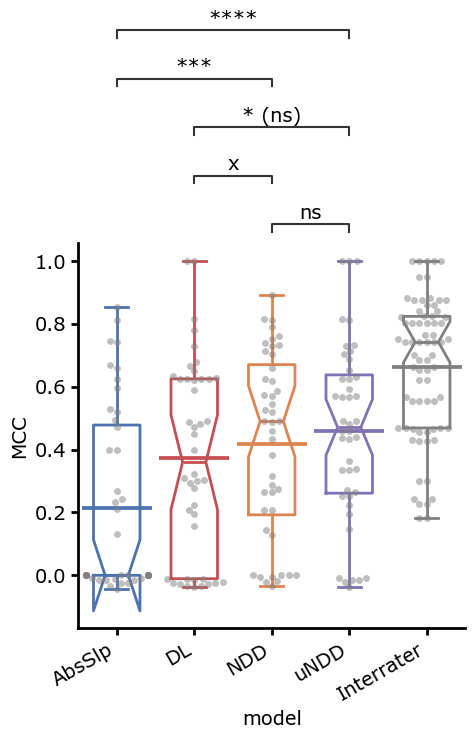

In [63]:
colors = np.array(sns.color_palette("deep", 5))
colors = colors[[0,3,1,4]]
_,ax = plt.subplots(figsize=(5,5))
sns.boxplot(unsupervised_df_wdice,x='model',y='dice',hue='model',palette=np.vstack([colors,[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','uNDD','Interrater'],
                 hue_order=['AbsSlp','DL','NDD','uNDD','Interrater'],
                 width=.6,notch=True,fill=False,
                 ax=ax,
                 whis=100)

sns.swarmplot(unsupervised_df_wdice,x='model',y='dice',color='gray',ax=ax,alpha=0.5)
sns.pointplot(unsupervised_df_wdice,x='model',y='dice',
              palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              hue_order = ['AbsSlp','DL','NDD','uNDD','Interrater'],
              order = ['AbsSlp','DL','NDD','uNDD','Interrater'],
              marker='_',markersize=50,errorbar=None,
              estimator='mean',
              ax=ax)
# Annotating plot
annotator = Annotator(ax,[('uNDD','NDD'),('uNDD','DL'),('uNDD','AbsSlp'),('NDD','DL'),('NDD','AbsSlp')],
data=unsupervised_df_wdice,
order=['AbsSlp','DL','NDD','uNDD','Interrater'],
x='model',y='dice')

annotator.configure(test=custom_test,
        comparisons_correction="Benjamini-Hochberg",
        loc='outside',
        text_format='star',
        fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                        [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]])

annotator.apply_and_annotate()

sns.despine()
plt.xticks(rotation=30,ha='right')
plt.ylabel('MCC')
# plt.title('Unsupervised Onset Activity Detection')
plt.savefig(ospj(figpath,'unsupervised_onset_detection.pdf'),bbox_inches='tight')

In [47]:
all_ps = []
mdl_strs = unsupervised_df_wdice.model.unique()
for idx_mdl in range(len(mdl_strs)):
    for jdx_mdl in range(idx_mdl+1,len(mdl_strs)):
        i_mdl = mdl_strs[idx_mdl]
        j_mdl = mdl_strs[jdx_mdl]
        if (i_mdl != 'uNDD') & (j_mdl != 'uNDD'):
            continue
        print(i_mdl,j_mdl)
        print(np.median(unsupervised_df_wdice[unsupervised_df_wdice.model == i_mdl]['dice']), np.median(unsupervised_df_wdice[unsupervised_df_wdice.model == j_mdl]['dice']))
        stat,p = sc.stats.mannwhitneyu(unsupervised_df_wdice[unsupervised_df_wdice.model == i_mdl].dice,unsupervised_df_wdice[unsupervised_df_wdice.model == j_mdl].dice,alternative='greater')
        d=cohens_d(unsupervised_df_wdice[unsupervised_df_wdice.model == i_mdl]['dice'],
                 unsupervised_df_wdice[unsupervised_df_wdice.model == j_mdl]['dice'])
        all_ps.append(p)
        print(stat,p)
multipletests(all_ps[1:])

uNDD Interrater
0.47093857582163645 0.7419145777666348
915.5 0.9999497291155393
uNDD AbsSlp
0.47093857582163645 0.0
1353.0 0.0006480771708212116
uNDD NDD
0.47093857582163645 0.48958132856941056
1002.0 0.38989307327633027
uNDD DL
0.47093857582163645 0.3597213401601487
1125.0 0.09574364338747376


(array([ True, False, False]),
 array([0.00194297, 0.38989307, 0.18232044]),
 0.016952427508441503,
 0.016666666666666666)

## Onset Localization

In [48]:
ndd_vals = pd.read_pickle(ospj(prodatapath,"NDD_soz_localizations_nosmooth.pkl"))

In [49]:
consensus_annots['ueo_chs'] = consensus_annots.apply(lambda x: np.array(x.all_chs)[x.ueo_consensus],axis=1)
consensus_annots['sec_chs'] = consensus_annots.apply(lambda x: np.array(x.all_chs)[x.sec_consensus],axis=1)

In [50]:
ndd_vals.sort_values('approximate_onset',inplace=True)
consensus_annots.sort_values('approximate_onset',inplace=True)
# Creating a merged table with human and machine annotations based on approximate seizure onset time
ndd_vals_wannots = pd.merge_asof(ndd_vals,
                                    consensus_annots[['approximate_onset','patient','ueo_chs','sec_chs','ueo_consensus','sec_consensus']],
                                    on='approximate_onset',by='patient',
                                    tolerance = 240,
                                    direction='nearest')

In [51]:
def ch_soz(row):
    chs = row.channel.split('-')
    soz = row.ueo_chs
    if isinstance(soz,float):
        return False
    if len(soz) == 0:
        return False
    elif chs[0] in soz:
        return True
    else:
        return False
def ch_ssz(row):
    chs = row.channel.split('-')
    soz = row.sec_chs
    if isinstance(soz,float):
        return False
    if len(soz) == 0:
        return False
    elif chs[0] in soz:
        return True
    else:
        return False

In [52]:
ndd_vals_wannots['soz'] = ndd_vals_wannots.apply(ch_soz,axis=1)
ndd_vals_wannots['ssz'] = ndd_vals_wannots.apply(ch_ssz,axis=1)

In [53]:
plt_ndd_vals = ndd_vals_wannots[ndd_vals_wannots.model == 'LSTM'].groupby(['patient','soz'])[['onset_ndd','spread_ndd']].mean().reset_index()

819.0 6.038742331228548e-10
0.9738406658739596
4.480447985789791 4.850276118186445
1.194375548050266 0.40483758847305584
1.5992131365233218


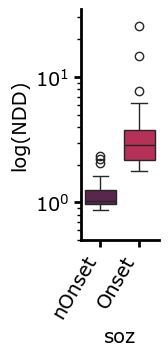

In [54]:
plt.figure(figsize=(1,3))
sns.boxplot(data=plt_ndd_vals,x='soz',y='onset_ndd',hue='soz',palette=sns.color_palette('rocket',n_colors=3)[:2],width=.8,legend=False)
sns.despine()
plt.xticks([0,1],['nOnset','Onset'],rotation=60,ha='right')
# plt.xlabel('SOZ')
plt.ylim([min(plt_ndd_vals.onset_ndd-.1),35])
plt.ylabel('log(NDD)')
plt.yscale('log')
plt.ylim([0.5,35])
mask1 = (plt_ndd_vals['soz'])
n1 = len(plt_ndd_vals[mask1])
n2 = len(plt_ndd_vals[~mask1])

u,p = sc.stats.mannwhitneyu(plt_ndd_vals[mask1].onset_ndd,plt_ndd_vals[~mask1].onset_ndd)
print(u,p)
print(u/(n1*n2))
print(plt_ndd_vals[mask1].onset_ndd.mean(), plt_ndd_vals[mask1].onset_ndd.std())
print(plt_ndd_vals[~mask1].onset_ndd.mean(), plt_ndd_vals[~mask1].onset_ndd.std())
print(plt_ndd_vals[~mask1].onset_ndd.mean() + plt_ndd_vals[~mask1].onset_ndd.std())
plt.savefig(ospj(figpath,'onset_localization.pdf'),bbox_inches='tight',transparent=True)

In [55]:
plt_ndd_vals = ndd_vals_wannots[ndd_vals_wannots.model == 'LSTM'].groupby(['patient','ssz'])[['onset_ndd','spread_ndd']].mean().reset_index()

4.968906865948589
1.297404190292352
769.0 7.192129366056184e-09
0.9470443349753694


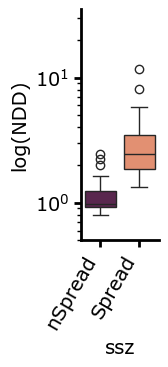

In [56]:
plt.figure(figsize=(1,3))
sns.boxplot(data=plt_ndd_vals,x='ssz',y='onset_ndd',hue='ssz',palette=sns.color_palette('rocket',n_colors=3)[::2],width=.8,legend=False)
sns.despine()
plt.xticks([0,1],['nSpread','Spread'],rotation=60,ha='right')
# plt.xlabel('SOZ')
plt.ylim([min(plt_ndd_vals.onset_ndd-.1),35])
plt.ylabel('log(NDD)')
plt.yscale('log')
plt.ylim([0.5,35])
mask1 = (plt_ndd_vals['ssz'])
n1 = len(plt_ndd_vals[mask1])
n2 = len(plt_ndd_vals[~mask1])
u,p = sc.stats.mannwhitneyu(plt_ndd_vals[mask1].spread_ndd,plt_ndd_vals[~mask1].spread_ndd);
print(plt_ndd_vals[mask1].spread_ndd.mean())
print(plt_ndd_vals[~mask1].spread_ndd.mean())
print(u,p)
print(u/(n1*n2))
plt.savefig(ospj(figpath,'spread_localization.pdf'),bbox_inches='tight',transparent=True)

## MCC evaluation

In [57]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus.pkl'))
consensus_annots = consensus_annots[consensus_annots.stim == 0]
consensus_annots = consensus_annots[consensus_annots.clinician.apply(lambda x: len(x)!=2)]
spread_consensus_annots = consensus_annots.copy()
note_type = 'ueo'
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2:
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += np.corrcoef((annots[i_annot],annots[j_annot]))[0][1]
    consensus_annots.loc[i_r,'MCC'] = scores/(len(annots)*(len(annots)-1)/2)
consensus_annots["model"] = ["Clin."]*len(consensus_annots)

In [58]:
ndd_vals_wannots = ndd_vals_wannots[ndd_vals_wannots.model == 'LSTM']
ndd_vals_wannots = ndd_vals_wannots[ndd_vals_wannots.stim == 0]

CHOP024 175520.91
CHOP044 29018.38
HUP225 393496.2
HUP225 408576.508
0.523619238530673 0.6543212352746098


ValueError: The samples x and y must have the same length.

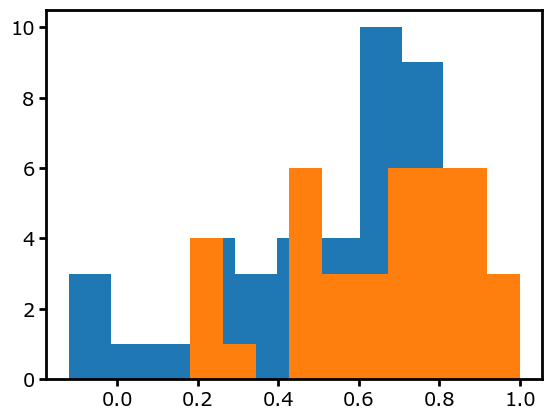

In [59]:
all_mccs = []
dict_list = []
for _,group in ndd_vals_wannots.groupby(['patient','approximate_onset','model']):
    # sns.lineplot(group,x='channel',y='soz')
    # sns.lineplot(group,x='channel',y='onset_ndd')
    r = group[['soz','onset_ndd']].corr().iloc[1,0]
    if np.isnan(r):
        print(group.patient.iloc[0],group.approximate_onset.iloc[0])
        continue
    dict_list.append({
        'patient': group.patient.iloc[0],
        'approximate_onset': group.approximate_onset.iloc[0],
        'MCC': r
    })
    all_mccs.append(r)
plt.hist(all_mccs)
plt.hist(consensus_annots['MCC'])
print(np.nanmean(all_mccs),np.nanmean(consensus_annots['MCC']))
sc.stats.wilcoxon(consensus_annots['MCC'][~consensus_annots.MCC.isna()],np.array(all_mccs)[~np.isnan(all_mccs)])

## Region Agreement

In [ ]:
predicted_channels = pd.read_pickle(ospj(prodatapath,"pretrain_predicted_channels_norsc.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

In [ ]:
# Go through the already created combined dataframe.
annotations_df = consensus_annots.copy()
annotations_df['Patient'] = annotations_df['patient']
pt_groups = annotations_df.groupby('Patient')
for pt,group in pt_groups:
    try:
        electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
    except:
        print(f'no regions for {pt}')
        continue
    for idx,row in group.iterrows():
        for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
            chs = np.array(row.all_chs)[row[col]]
            electrode_locals = electrode_regions[electrode_regions.name.isin(chs)]['label'].unique()
            annotations_df.at[idx,col+'_rs'] = electrode_locals
        annotations_df.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_chs'])]['label'].unique()
annotations_df.sort_values('approximate_onset',inplace=True)

no regions for CHOP015
no regions for CHOP038


In [ ]:
pt_groups = predicted_channels.groupby('Patient')
for pt,group in pt_groups:
    try:
        electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
    except:
        print(f'no regions for {pt}')
        continue
    for idx,row in group.iterrows():
        for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
            electrode_locals = electrode_regions[electrode_regions.name.isin(row[col])]['label'].unique()
            predicted_channels.at[idx,col.split('_')[0]+'_rs_'+col.split('_')[2]] = electrode_locals
predicted_channels.sort_values('approximate_onset',inplace=True)
pred_regions_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_rs','ueo_consensus_rs','ueo_any_rs','sec_consensus_rs','sec_any_rs']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_regions_wannots.dropna(axis=0,subset='ueo_consensus_rs',inplace=True)
pred_regions_wannots.sort_values(['Patient','iEEG_ID','approximate_onset','threshold','model'],inplace=True)
# pred_regions_wkappa = pred_regions_wannots.apply(apply_region_kappa,axis=1)

KeyboardInterrupt: 

In [ ]:
pred_regions_wannots.to_pickle(ospj(prodatapath,'pred_regions_wannots.pkl'))

In [ ]:
pred_regions_wannots

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,to_annotate,ueo_rs_strict,ueo_rs_loose,sec_rs_strict,sec_rs_loose,all_rs,ueo_consensus_rs,ueo_any_rs,sec_consensus_rs,sec_any_rs
140497,CHOP041,CHOP041,AbsSlp,0.0,416768.18,416768.18,0.000000,"[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,1.0,"[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[Left-Amygdala, Left-Cerebral-White-Matter, Le...","[Left-Amygdala, Left-Cerebral-White-Matter, Le..."
140997,CHOP041,CHOP041,LSTM,0.0,416768.18,416768.18,0.000000,"[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,1.0,"[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[Left-Amygdala, Left-Cerebral-White-Matter, Le...","[Left-Amygdala, Left-Cerebral-White-Matter, Le..."
140999,CHOP041,CHOP041,NRG,0.0,416768.18,416768.18,0.000000,"[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,1.0,"[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[Left-Amygdala, Left-Cerebral-White-Matter, Le...","[Left-Amygdala, Left-Cerebral-White-Matter, Le..."
141658,CHOP041,CHOP041,WVNT,0.0,416768.18,416768.18,0.000000,"[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,1.0,"[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[Left-Amygdala, Left-Cerebral-White-Matter, Le...","[Left-Amygdala, Left-Cerebral-White-Matter, Le..."
140337,CHOP041,CHOP041,AbsSlp,0.0,416768.18,416768.18,0.006012,"[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...","[LJ01, LJ02, LJ03, LJ04, LJ05, LJ06, LJ07, LJ0...",...,1.0,"[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[Left-Amygdala, Left-Cerebral-White-Matter, ct...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[ctx-lh-superiortemporal, Left-Cerebral-White-...","[Left-Amygdala, Left-Cerebral-White-Matter, Le...","[Left-Amygdala, Left-Cerebral-White-Matter, Le..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99999,HUP288,HUP288_phaseII,WVNT,0.0,251098.53,251098.53,2.993988,[],[],[],...,1.0,[],[],[],[],"[EmptyLabel, right inferior parietal , right...",[],[],[],[]
98997,HUP288,HUP288_phaseII,AbsSlp,

In [ ]:
pred_regions_wannots.apply(apply_region_dice,axis=1)

KeyError: 'ueo_consensus'

In [ ]:
def apply_region_dice(row):
    all_rs = row.all_rs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row